## Jazz Coffee Shop Data Visualization
### To facilitate separate data wrangling and analysis

In [1]:

import numpy as np # library to handle data in a vectorized manner
import pandas as pd # library for data analsysis
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

import json # library to handle JSON files
#!conda install -c conda-forge geopy --yes 

from geopy.geocoders import Nominatim # convert an address into latitude and longitude values

import requests # library to handle requests

from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe
# Matplotlib and associated plotting modules

import matplotlib.cm as cm
import matplotlib.colors as colors
import matplotlib as mpl
import matplotlib.pyplot as plt

mpl.style.use('ggplot')

print ('Matplotlib version: ', mpl.__version__) 

Matplotlib version:  3.0.2


### Pull the NYC Neighborhood data and creat the core dataframe

In [2]:
# Get the NYC json data, this is publically available via an NYU-hosted site.
!wget -q -O 'newyork_data.json' https://cocl.us/new_york_dataset
print('Data downloaded!')

Data downloaded!


In [5]:
with open('newyork_data.json') as json_data:
    newyork_data = json.load(json_data)
    
print('Data loaded!')

Data loaded!


In [6]:
# Pull only the data we need, which is all in the "features" group within the json data set
neighborhoods_data = newyork_data['features']

In [7]:
# define the dataframe columns
column_names = ['Borough', 'Neighborhood', 'Latitude', 'Longitude'] 

# instantiate the dataframe
neighborhoods = pd.DataFrame(columns=column_names)

In [8]:
# Now populate the dataframe
for data in neighborhoods_data:
    borough = neighborhood_name = data['properties']['borough'] 
    neighborhood_name = data['properties']['name']
        
    neighborhood_latlon = data['geometry']['coordinates']
    neighborhood_lat = neighborhood_latlon[1]
    neighborhood_lon = neighborhood_latlon[0]
    
    neighborhoods = neighborhoods.append({'Borough': borough,
                                          'Neighborhood': neighborhood_name,
                                          'Latitude': neighborhood_lat,
                                          'Longitude': neighborhood_lon}, ignore_index=True)

### Let's confirm the data was written as expected

In [9]:
neighborhoods.shape

(306, 4)

### Set up what we need for our Foursquare calls

In [12]:
neighborhood_latitude = neighborhoods.loc[0, 'Latitude'] # neighborhood latitude value
neighborhood_longitude = neighborhoods.loc[0, 'Longitude'] # neighborhood longitude value

neighborhood_name = neighborhoods.loc[0, 'Neighborhood'] # neighborhood name

print('Latitude and longitude values of {} are {}, {}.'.format(neighborhood_name, 
                                                               neighborhood_latitude, 
                                                               neighborhood_longitude))

Latitude and longitude values of Wakefield are 40.89470517661, -73.84720052054902.


In [13]:

CLIENT_ID = 'XKM1WICJGVYJNATDLMBDGCFTGX55SIKVEIFLD4U2IPJW5TIL' # your Foursquare ID
CLIENT_SECRET = 'AEROXK2QCML5HNEKG1G4RBYZIL0X5OOS1QP3VXOMDHSQAXC2' # your Foursquare Secret
VERSION = '20180605' # Foursquare API version

print('Your credentails:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)

Your credentails:
CLIENT_ID: XKM1WICJGVYJNATDLMBDGCFTGX55SIKVEIFLD4U2IPJW5TIL
CLIENT_SECRET:AEROXK2QCML5HNEKG1G4RBYZIL0X5OOS1QP3VXOMDHSQAXC2


In [14]:

# Now Define the Foursquare url NOTE updated radius to 800
LIMIT=100
radius=800
url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
    CLIENT_ID, CLIENT_SECRET, VERSION, neighborhood_latitude, neighborhood_longitude, radius, LIMIT)

url

'https://api.foursquare.com/v2/venues/explore?&client_id=XKM1WICJGVYJNATDLMBDGCFTGX55SIKVEIFLD4U2IPJW5TIL&client_secret=AEROXK2QCML5HNEKG1G4RBYZIL0X5OOS1QP3VXOMDHSQAXC2&v=20180605&ll=40.89470517661,-73.84720052054902&radius=800&limit=100'

### Let's pull the data

In [15]:
# get the results of the url
results = requests.get(url).json()

In [16]:
# New function to pull category type
def get_category_type(row):
    try:
        categories_list = row['categories']
    except:
        categories_list = row['venue.categories']
        
    if len(categories_list) == 0:
        return None
    else:
        return categories_list[0]['name']

### Now we pull the nearby venues

In [17]:

venues = results['response']['groups'][0]['items']
    
nearby_venues = json_normalize(venues) # flatten JSON

# filter columns
filtered_columns = ['venue.name', 'venue.categories', 'venue.location.lat', 'venue.location.lng']
nearby_venues =nearby_venues.loc[:, filtered_columns]

# filter the category for each row
nearby_venues['venue.categories'] = nearby_venues.apply(get_category_type, axis=1)

# clean columns
nearby_venues.columns = [col.split(".")[-1] for col in nearby_venues.columns]

nearby_venues

,name,categories,lat,lng
0,Lollipops Gelato,Dessert Shop,40.894123,-73.845892
1,Rite Aid,Pharmacy,40.896649,-73.844846
2,Ripe Kitchen & Bar,Caribbean Restaurant,40.898152,-73.838875
3,Jackie's West Indian Bakery,Caribbean Restaurant,40.889283,-73.843310
4,Carvel Ice Cream,Ice Cream Shop,40.890487,-73.848568
5,Rite Aid,Pharmacy,40.889062,-73.842993
6,Cooler Runnings Jamaican Restaurant Inc,Caribbean Restaurant,40.898276,-73.850381
7,Dunkin',Donut Shop,40.890459,-73.849089
8,SUBWAY,Sandwich Place,40.890656,-73.849192
9,Walgreens,Pharmacy,40.898757,-73.854446


### Pull the venues for every neighborhood in New York City

In [18]:

def getNearbyVenues(names, latitudes, longitudes, radius=500):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
        
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

In [19]:
newyorkcity_venues = getNearbyVenues(names=neighborhoods['Neighborhood'],
                                   latitudes=neighborhoods['Latitude'],
                                   longitudes=neighborhoods['Longitude']
                                  )

Wakefield
Co-op City
Eastchester
Fieldston
Riverdale
Kingsbridge
Marble Hill
Woodlawn
Norwood
Williamsbridge
Baychester
Pelham Parkway
City Island
Bedford Park
University Heights
Morris Heights
Fordham
East Tremont
West Farms
High  Bridge
Melrose
Mott Haven
Port Morris
Longwood
Hunts Point
Morrisania
Soundview
Clason Point
Throgs Neck
Country Club
Parkchester
Westchester Square
Van Nest
Morris Park
Belmont
Spuyten Duyvil
North Riverdale
Pelham Bay
Schuylerville
Edgewater Park
Castle Hill
Olinville
Pelham Gardens
Concourse
Unionport
Edenwald
Bay Ridge
Bensonhurst
Sunset Park
Greenpoint
Gravesend
Brighton Beach
Sheepshead Bay
Manhattan Terrace
Flatbush
Crown Heights
East Flatbush
Kensington
Windsor Terrace
Prospect Heights
Brownsville
Williamsburg
Bushwick
Bedford Stuyvesant
Brooklyn Heights
Cobble Hill
Carroll Gardens
Red Hook
Gowanus
Fort Greene
Park Slope
Cypress Hills
East New York
Starrett City
Canarsie
Flatlands
Mill Island
Manhattan Beach
Coney Island
Bath Beach
Borough Park
Dyker

In [20]:
# Check the new dataframe
print(newyorkcity_venues.shape)
newyorkcity_venues.head()

(10378, 7)


,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Wakefield,40.894705,-73.847201,Lollipops Gelato,40.894123,-73.845892,Dessert Shop
1,Wakefield,40.894705,-73.847201,Rite Aid,40.896649,-73.844846,Pharmacy
2,Wakefield,40.894705,-73.847201,Carvel Ice Cream,40.890487,-73.848568,Ice Cream Shop
3,Wakefield,40.894705,-73.847201,Cooler Runnings Jamaican Restaurant Inc,40.898276,-73.850381,Caribbean Restaurant
4,Wakefield,40.894705,-73.847201,Dunkin',40.890459,-73.849089,Donut Shop


### Looks good. Let's create a dataframe just for the venues of interest

In [21]:

capstone_venues = ['Record Shop', 'Performing Arts Venue', 'Jazz Club', 'Concert Hall', 'Music School', 'Music Venue', 'Nightclub', 'Opera House', 'Coffee Shop']
filtered_venues=newyorkcity_venues[newyorkcity_venues['Venue Category'].isin(capstone_venues)]

filtered_venues.head(10)

,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
81,Kingsbridge,40.881687,-73.902818,Mon Amour Coffee & Wine,40.885009,-73.900332,Coffee Shop
136,Marble Hill,40.876551,-73.910660,Starbucks,40.877531,-73.905582,Coffee Shop
145,Marble Hill,40.876551,-73.910660,Starbucks,40.873755,-73.908613,Coffee Shop
184,Norwood,40.877224,-73.879391,Nicky's Coffee Shop,40.874933,-73.879404,Coffee Shop
212,Williamsbridge,40.881039,-73.857446,Club Mystique,40.884149,-73.856476,Nightclub
247,Pelham Parkway,40.857413,-73.854756,Liberty Donut & Coffee Shop,40.855339,-73.855333,Coffee Shop
248,Pelham Parkway,40.857413,-73.854756,Bronx house,40.856689,-73.860467,Performing Arts Venue
277,City Island,40.847247,-73.786488,Starving Artist Cafe & Gallery,40.845420,-73.785806,Music Venue
370,Fordham,40.860997,-73.896427,Paradise Theater,40.860499,-73.898463,Music Venue
492,West Farms,40.839475,-73.877745,Prospect Coffee Shop,40.837577,-73.880839,Coffee Shop


In [22]:
# one hot encoding
newyorkcity_onehot = pd.get_dummies(filtered_venues[['Venue Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
newyorkcity_onehot['Neighborhood'] = filtered_venues['Neighborhood'] 

# move neighborhood column to the first column
fixed_columns = [newyorkcity_onehot.columns[-1]] + list(newyorkcity_onehot.columns[:-1])
newyorkcity_onehot = newyorkcity_onehot[fixed_columns]

newyorkcity_onehot.head()

,Neighborhood,Coffee Shop,Concert Hall,Jazz Club,Music School,Music Venue,Nightclub,Opera House,Performing Arts Venue,Record Shop
81,Kingsbridge,1,0,0,0,0,0,0,0,0
136,Marble Hill,1,0,0,0,0,0,0,0,0
145,Marble Hill,1,0,0,0,0,0,0,0,0
184,Norwood,1,0,0,0,0,0,0,0,0
212,Williamsbridge,0,0,0,0,0,1,0,0,0


### Now we'll split the data into 2 dataframes: one just for coffee shops, the other for musical venues

In [23]:
# First create the df with just Neighborhood and Coffee Shop as columns
newyorkcity_onehot_coffee=newyorkcity_onehot[['Neighborhood','Coffee Shop']].groupby('Neighborhood').count()

In [24]:
# Next create only musical venues - Drop "Coffee Shop" from the data set
newyorkcity_onehot_nocoffee=newyorkcity_onehot.drop(['Coffee Shop'], axis=1)

newyorkcity_onehot_nocoffee.head()

,Neighborhood,Concert Hall,Jazz Club,Music School,Music Venue,Nightclub,Opera House,Performing Arts Venue,Record Shop
81,Kingsbridge,0,0,0,0,0,0,0,0
136,Marble Hill,0,0,0,0,0,0,0,0
145,Marble Hill,0,0,0,0,0,0,0,0
184,Norwood,0,0,0,0,0,0,0,0
212,Williamsbridge,0,0,0,0,1,0,0,0


### Add a Total column then remove any neighborhoods with zero

In [25]:
# For our analysis let's add a total column
newyorkcity_onehot_nocoffee['Total'] = newyorkcity_onehot_nocoffee.sum(axis=1)

# let's view the first five elements and see how the dataframe was changed
newyorkcity_onehot_nocoffee.head()

,Neighborhood,Concert Hall,Jazz Club,Music School,Music Venue,Nightclub,Opera House,Performing Arts Venue,Record Shop,Total
81,Kingsbridge,0,0,0,0,0,0,0,0,0
136,Marble Hill,0,0,0,0,0,0,0,0,0
145,Marble Hill,0,0,0,0,0,0,0,0,0
184,Norwood,0,0,0,0,0,0,0,0,0
212,Williamsbridge,0,0,0,0,1,0,0,0,1


In [41]:
# Let's drop the neighborhoods with zero venues

newyorkcity_nocoffee_nozero = newyorkcity_onehot_nocoffee[newyorkcity_onehot_nocoffee.Total != 0]

newyorkcity_nocoffee_nozero = newyorkcity_nocoffee_nozero.reset_index(drop=True)

newyorkcity_nocoffee_nozero.head()

,Neighborhood,Concert Hall,Jazz Club,Music School,Music Venue,Nightclub,Opera House,Performing Arts Venue,Record Shop,Total
0,Williamsbridge,0,0,0,0,1,0,0,0,1
1,Pelham Parkway,0,0,0,0,0,0,1,0,1
2,City Island,0,0,0,1,0,0,0,0,1
3,Fordham,0,0,0,1,0,0,0,0,1
4,Port Morris,0,0,0,1,0,0,0,0,1


In [88]:
newyorkcity_nocoffee_nozero.shape

(108, 9)

In [89]:
nyc_nocoff_nozero=newyorkcity_nocoffee_nozero

In [90]:
nyc_nocoff_nozero.head()

,Concert Hall,Jazz Club,Music School,Music Venue,Nightclub,Opera House,Performing Arts Venue,Record Shop,Total
Neighborhood,,,,,,,,,
Williamsbridge,0,0,0,0,1,0,0,0,1
Prospect Heights,0,0,0,1,0,0,0,0,1
City Island,0,0,0,1,0,0,0,0,1
Fordham,0,0,0,1,0,0,0,0,1
Port Morris,0,0,0,1,0,0,0,0,1


In [134]:
# Let's group it by Neighborhood and check the shape
grouped_data=nyc_nocoff_nozero.groupby('Neighborhood').count()

In [93]:
grouped_data.shape


(58, 9)

In [94]:
grouped_data.sort_values(by=['Total'], inplace=True, ascending=False)

### Let's take a look at the grouped and sorted data

In [95]:
grouped_data.head(10)

,Concert Hall,Jazz Club,Music School,Music Venue,Nightclub,Opera House,Performing Arts Venue,Record Shop,Total
Neighborhood,,,,,,,,,
Lincoln Square,11,11,11,11,11,11,11,11,11
East Williamsburg,7,7,7,7,7,7,7,7,7
West Village,4,4,4,4,4,4,4,4,4
Greenpoint,4,4,4,4,4,4,4,4,4
Chelsea,4,4,4,4,4,4,4,4,4
Gowanus,4,4,4,4,4,4,4,4,4
Fort Greene,4,4,4,4,4,4,4,4,4
Jamaica Center,3,3,3,3,3,3,3,3,3
Hudson Yards,3,3,3,3,3,3,3,3,3


In [97]:
# I wanted to reset the index before continuing
grouped_data.reset_index()

,Neighborhood,Concert Hall,Jazz Club,Music School,Music Venue,Nightclub,Opera House,Performing Arts Venue,Record Shop,Total
0,Lincoln Square,11,11,11,11,11,11,11,11,11
1,East Williamsburg,7,7,7,7,7,7,7,7,7
2,West Village,4,4,4,4,4,4,4,4,4
3,Greenpoint,4,4,4,4,4,4,4,4,4
4,Chelsea,4,4,4,4,4,4,4,4,4
5,Gowanus,4,4,4,4,4,4,4,4,4
6,Fort Greene,4,4,4,4,4,4,4,4,4
7,Jamaica Center,3,3,3,3,3,3,3,3,3
8,Hudson Yards,3,3,3,3,3,3,3,3,3
9,Boerum Hill,3,3,3,3,3,3,3,3,3


### Create a data frame just with Neighborhood and Column, then do a count to see how many total musical venues we have

In [101]:
grouped_data = grouped_data.reindex(columns=['Neighborhood', 'Total'])

In [104]:
grouped_data_new = grouped_data[['Total']].copy()

In [131]:
Total = grouped_data_new['Total'].sum()
print (Total)

108


In [130]:
top_ten_neigh=grouped_data_new.head(10)

### First let's take a look at our top 10 Music neighborhoods

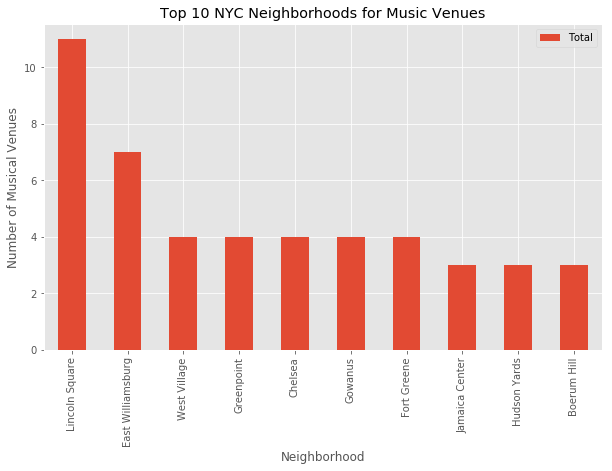

In [109]:
top_ten_neigh.plot(kind='bar', figsize=(10, 6))

plt.xlabel('Neighborhood') # add to x-label to the plot
plt.ylabel('Number of Musical Venues') # add y-label to the plot
plt.title('Top 10 NYC Neighborhoods for Music Venues') # add title to the plot

plt.show()

### Now we can work on our Coffee Shop density

In [125]:
#newyorkcity_onehot_coffee.head()
newyorkcity_onehot_coffee.sort_values(by=['Coffee Shop'], inplace=True, ascending=False)

In [126]:
newyorkcity_onehot_coffee.head(5)

,Coffee Shop
Neighborhood,
Lincoln Square,12
East Williamsburg,11
Greenpoint,10
Financial District,10
Chelsea,10


In [132]:
Total_coffee = newyorkcity_onehot_coffee['Coffee Shop'].sum()
print (Total_coffee)

384


In [127]:
nyc_coffee_top = newyorkcity_onehot_coffee.head(20)


In [128]:
nyc_coffee_top

,Coffee Shop
Neighborhood,
Lincoln Square,12
East Williamsburg,11
Greenpoint,10
Financial District,10
Chelsea,10
Long Island City,9
Battery Park City,8
Murray Hill,8
West Village,7


### Let's visualize this data

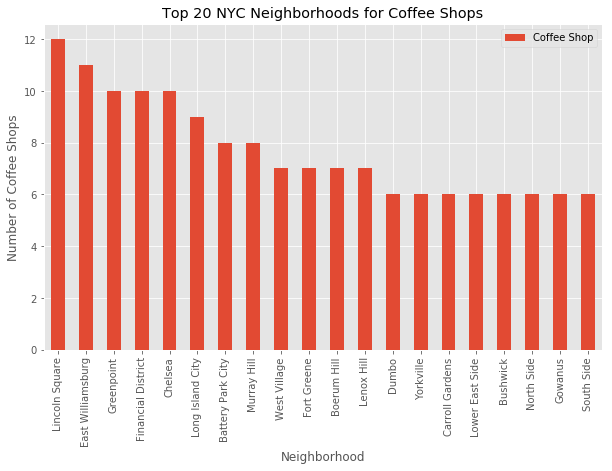

In [129]:
nyc_coffee_top.plot(kind='bar', figsize=(10, 6))

plt.xlabel('Neighborhood') # add to x-label to the plot
plt.ylabel('Number of Coffee Shops') # add y-label to the plot
plt.title('Top 20 NYC Neighborhoods for Coffee Shops') # add title to the plot

plt.show()